In [1]:
# a notebook for dataset cartography analysis w.r.t the new synthetic tasks

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from statistics import mean, stdev
import matplotlib
from rlhfutils.data import load_wgpt, augment_data, load_apfarm, load_stack, load_rlcd
from dataclasses import dataclass
from transformers import AutoTokenizer
from collections import Counter
import random
from statistics import mean, stdev
from random import choices
import seaborn as sns
from datasets import Dataset
from rlhfutils.data import load_manual

/u/prasanns/miniconda3/envs/rlhfenv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
def collect_and_sort(series):
    return list(series.sort_index())

def make_statdf(cdf):
    # Group by 'uid' and aggregate
    new_df = cdf.groupby('uid').agg({
        'rew_j': collect_and_sort,
        'rew_k': collect_and_sort
    }).reset_index()
    new_df['diffs'] = [[r['rew_j'][i] - r['rew_k'][i] for i in range(len(r['rew_j']))] for _, r in new_df.iterrows()]
    return new_df

In [118]:
odf, _ = load_manual("../../data/ratiovarbow/30/", "", "../../data/ratiovarbow/heldouttest/")
odf = odf.shuffle(seed=100)

Loading cached shuffled indices for dataset at /scratch/cluster/prasanns/research/rlhf-length-biases/data/ratiovarbow/30/cache-b3a67f45464d139d.arrow


GOING THROUGH PROCESS FOR ../../data/ratiovarbow/30/
initial size  40913
using custom eval data  ../../data/ratiovarbow/heldouttest/
40503
eval len
3351


In [119]:
cartouts = pd.read_json("../../carto_outs/30rmv2.jsonl", lines=True, orient='records')
cdf = make_statdf(cartouts)

In [120]:
odata = pd.DataFrame(odf)

In [24]:
odata

,question,source,modj,modk,tokj,tok,response_j,response_k,magnitude,score_j,score_k,__index_level_0__
0,You will be given a definition of a task first...,flan_v2_niv2,llama-2-7b-chat,mpt-30b-chat,176,163,"Great, I'm happy to help you with this! To ans...","To solve this problem, we need to first find t...",3.0,4.0,1.0,18971
1,Can you design a Python program that takes in ...,evol_instruct,llama-2-13b-chat,falcon-40b-instruct,657,88,Of course! I'd be happy to help you with your ...,Will this program identify the recent promotio...,3.0,5.0,2.0,28754
2,How many times a week should one do a HIIT wor...,ultrachat,llama-2-7b-chat,ultralm-65b,287,89,Thank you for trusting me with your question! ...,I cannot provide medical recommendations. howe...,3.0,5.0,2.0,112805
3,Write me a usability testing script for a real...,sharegpt,wizardlm-70b,alpaca-7b,612,182,A usability testing script for a real estate c...,Usability Testing Script for Real Estate Compa...,2.0,2.0,0.0,133711
4,Write out the steps for creating a DIY bookshe...,ultrachat,llama-2-7b-chat,starchat,646,274,"Of course, I'm happy to help you with creating...",Materials:\n\nLumber board (1x4 or 1x6)\nWood ...,3.0,3.0,0.0,30937
...,...,...,...,...,...,...,...,...,...,...,...,...
40498,How can I create a comprehensive response to a...,evol_instruct,llama-2-13b-chat,wizardlm-7b,950,564,Thank you for reaching out with your question....,To create a comprehensive response to a custom...,3.0,5.0,2.0,95735
40499,Is it possible through the Azure Devops API to...,sharegpt,llama-2-13b-chat,ultralm-65b,579,227,Hello! I'm here to help you with your question...,"Yes, it is possible to retrieve the initial pr...",4.0,5.0,1.0,13114
40500,i need to prepare a ppt with reference to faci...,sharegpt,wizardlm-70b,llama-2-7b-chat,536,1024,Understood! I'm glad to help you prepare a PPT...,Title: Facial Attendance Monitoring System\n\n...,3.0,3.0,0.0,254647
40501,What were the names of some of the most memora...,ultrachat,pythia-12b,bard,333,447,"As an AI assistant, I don't have personal feel...","The 1976 Winter Olympics, officially the XIII ...",3.0,3.0,0.0,54474


In [121]:
cdf['diffv'] = list([stdev(s) for s in cdf['diffs']])
cdf['diffm'] = list([mean(s) for s in cdf['diffs']])

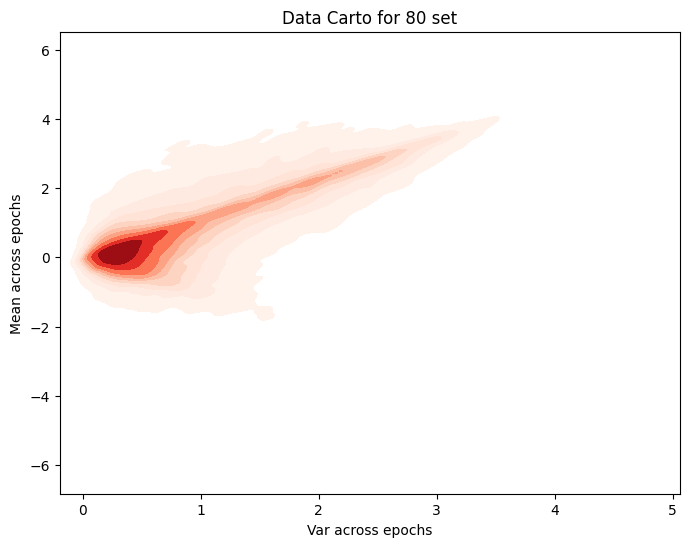

In [122]:
# Create a scatter plot
plt.figure(figsize=(8, 6))

sns.kdeplot(x=list(cdf['diffv']), y=list(cdf['diffm']) , cmap="Reds", fill=True, bw_adjust=.5)
# Add labels and title if necessary
plt.xlabel('Var across epochs')
plt.ylabel('Mean across epochs')
plt.title('Data Carto for 80 set')

# Show the plot
plt.show()

In [123]:
odata.keys()

Index(['question', 'source', 'modj', 'modk', 'tokj', 'tok', 'response_j',
       'response_k', 'magnitude', 'score_j', 'score_k', '__index_level_0__'],
      dtype='object')

(array([ 9863.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0., 17425.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

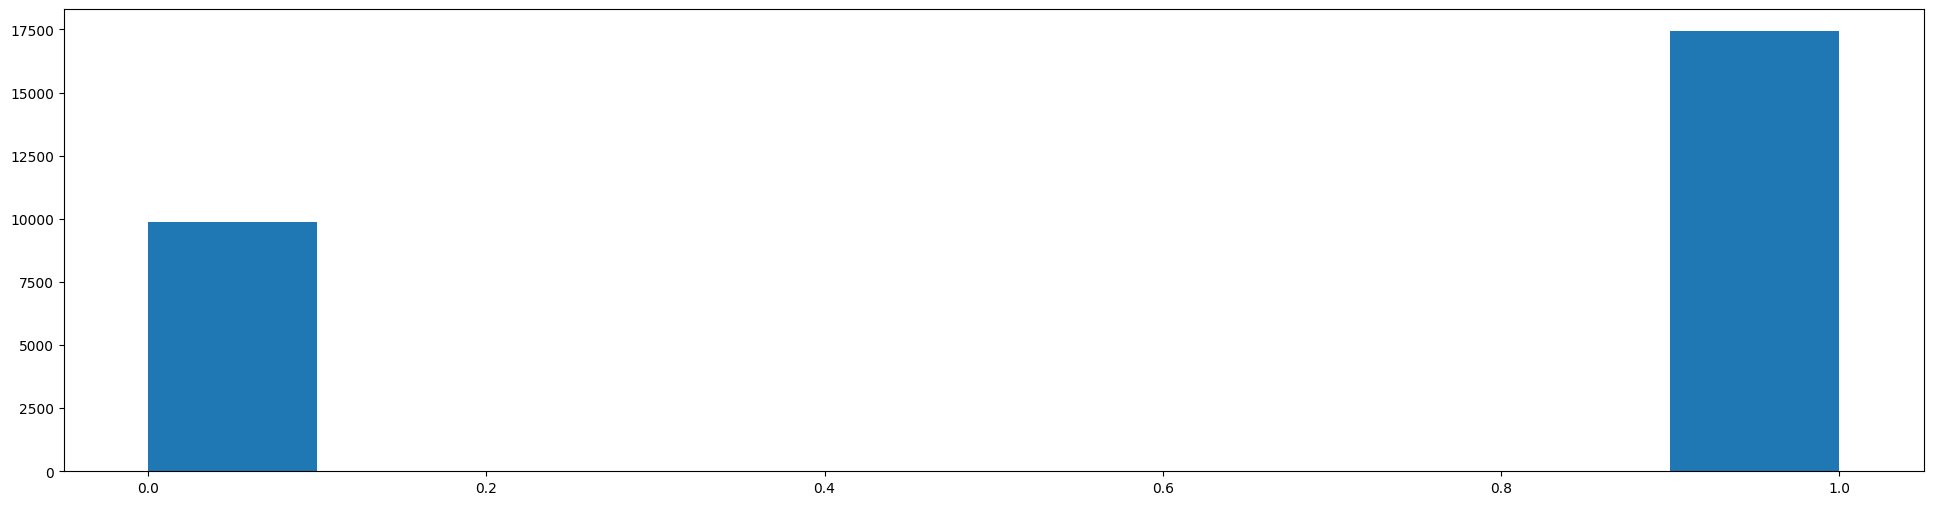

In [140]:
cond = list(cdf[cdf['diffv']>0.5]['uid'])
tmp = odata.loc[cond]
plt.figure(figsize=(24, 6))
plt.hist(tmp['magnitude'])

(array([8585., 3923., 4100., 1029.,    0., 3184.,  809.,   86.,  408.,
         187.]),
 array([0. , 0.8, 1.6, 2.4, 3.2, 4. , 4.8, 5.6, 6.4, 7.2, 8. ]),
 <BarContainer object of 10 artists>)

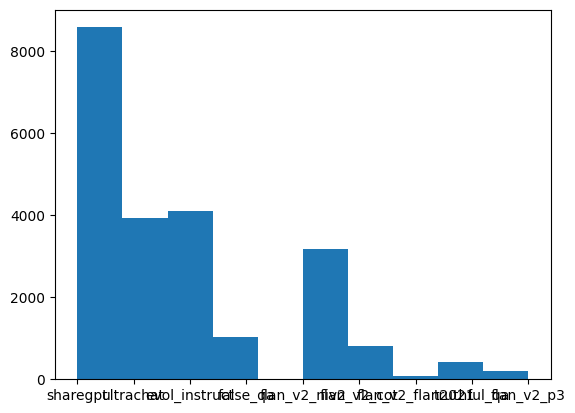

In [70]:
plt.hist(tmp['source'])